In [13]:
# Import libraries
import pandas as pd
from matplotlib import pyplot as plt
import sqlite3

In [14]:
#Import raw events for analysis
raw_events = pd.read_excel("Alert-Bank.xlsx")
raw_events.shape

(1051, 9)

In [15]:
raw_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Host              1051 non-null   object        
 1   AlertTime         1051 non-null   datetime64[ns]
 2   AlertDescription  1051 non-null   object        
 3   AlertClass        1051 non-null   object        
 4   AlertType         1051 non-null   object        
 5   AlertManager      1051 non-null   object        
 6   Source            1051 non-null   object        
 7   Status            1051 non-null   int64         
 8   Severity          1051 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 74.0+ KB


In [16]:
raw_events.head().transpose()

,0,1,2,3,4
Host,AUPRDGLB-HRAPP03,USPRDEMPRECWEB03,USDEVGLB-HRAPP02,UKDEVPAYROLDBA01,dummy.au-x6.global.com
AlertTime,2021-06-02 03:56:34.995000,2021-06-02 05:55:32,2021-06-02 07:50:33.995000,2021-06-02 07:50:47.995000,2021-06-02 10:49:53.995000
AlertDescription,Memory Utilization is 74% in Warning State on...,Memory Utilization is 70% in Warning State on...,CPU Utilization is 95% in Critical State on U...,CPU Utilization is 93% in Critical State on U...,Interface Utilization is 75% in Warning State...
AlertClass,OperatingSystem,OperatingSystem,OperatingSystem,OperatingSystem,network performance
AlertType,Server,Server,Server,Server,network
AlertManager,PlatformMonitoring-Tool,PlatformMonitoring-Tool,PlatformMonitoring-Tool,PlatformMonitoring-Tool,network-monitoring-tool
Source,Memory,Memory,CPU,CPU,Interface
Status,3,1,1,1,1
Severity,2,2,1,1,2


In [17]:
raw_events['Status'].unique()

array([3, 1, 2])

In [18]:
raw_events['Severity'].unique()

array([2, 1])

In [19]:
#Create EMUniqueKey for performing DeDuplication Function
raw_events['EMUniqueKey'] = raw_events['Host'].str.strip() + "::" \
                    + raw_events['Source'].str.strip() + "::" \
                + raw_events['AlertType'].str.strip() + "::" \
                + raw_events['AlertManager'].str.strip() + "::" \
                + raw_events['AlertClass'].str.strip()
raw_events['EMUniqueKey'] = raw_events['EMUniqueKey'].str.lower()
raw_events = raw_events.sort_values(by="AlertTime")
raw_events["AlertTime"] = raw_events["AlertTime"].astype(str)

raw_events.head().transpose()

,0,1,2,3,4
Host,AUPRDGLB-HRAPP03,USPRDEMPRECWEB03,USDEVGLB-HRAPP02,UKDEVPAYROLDBA01,dummy.au-x6.global.com
AlertTime,2021-06-02 03:56:34.995,2021-06-02 05:55:32.000,2021-06-02 07:50:33.995,2021-06-02 07:50:47.995,2021-06-02 10:49:53.995
AlertDescription,Memory Utilization is 74% in Warning State on...,Memory Utilization is 70% in Warning State on...,CPU Utilization is 95% in Critical State on U...,CPU Utilization is 93% in Critical State on U...,Interface Utilization is 75% in Warning State...
AlertClass,OperatingSystem,OperatingSystem,OperatingSystem,OperatingSystem,network performance
AlertType,Server,Server,Server,Server,network
AlertManager,PlatformMonitoring-Tool,PlatformMonitoring-Tool,PlatformMonitoring-Tool,PlatformMonitoring-Tool,network-monitoring-tool
Source,Memory,Memory,CPU,CPU,Interface
Status,3,1,1,1,1
Severity,2,2,1,1,2
EMUniqueKey,auprdglb-hrapp03::memory::server::platformmoni...,usprdemprecweb03::memory::server::platformmoni...,usdevglb-hrapp02::cpu::server::platformmonitor...,ukdevpayroldba01::cpu::server::platformmonitor...,dummy.au-x6.global.com::interface::network::ne...


# SQLITE Database helper class

In [20]:
'''
To make model scalable let's transform events data from array to 
dictionary datatype and store events in Key:value format.

This will allow referencing by slot name instead of using
array indexes.
'''
def transform_dictionary(cursor, row):
    key_value = {}
    for idx, col in enumerate(cursor.description):
        key_value[col[0]] = row[idx]
    return key_value

class Database:

# create db connection to store and process events.

    def __init__(self):
        self._con = sqlite3.connect('events.db')
        self._con.row_factory = transform_dictionary
        self.cur = self._con.cursor()
        self.createTable()

    def getConn(self):
        return self._con

    '''
    Create required tables in database.
    We only need one table to store the final de-duplicated events.
    However we are also creating archive table which will store the
    duplicated events. This table will be used at end to quantify the
    benefits of de-duplication function.
    '''

    def createTable(self):
        self.cur.execute('''CREATE TABLE if not exists dedup
                (AlertTime date, EMUniqueKey text, Host text, \
                AlertDescription text, AlertClass text, AlertType text, \
                AlertManager text, Source text, Status text, \
                Severity text, Count real)''')
        self.cur.execute('''CREATE TABLE if not exists archive
                (AlertTime date, EMUniqueKey text, Host text, 
                AlertDescription text, AlertClass text, AlertType text,\
                AlertManager text, Source text, Status text, \
                Severity text)''')
 
    def execute(self, query):
        self.cur.execute(query)
        
    def update(self, query, values):
        # print(query)
        return self.cur.execute(query, values)
    """
    Insert data values in table as Key:Value pair with column name as key.
    """    
    def insert(self, table, values):
        
        columns = []
        val = []
        value = []

        for EMUniqueKey in values:
            columns.append(EMUniqueKey)
            val.append("?")
            value.append(values[EMUniqueKey])

        query = "Insert into {} ({}) values ({})".format\
        (table, ",".join(columns), ",".join(val) )
        
        self.cur.execute(query, tuple(value))

    def fetchOne(self, query):
        self.cur.execute(query)
        return self.cur.fetchone()
        

    def fetchAll(self, query):
        self.cur.execute(query)
        return self.cur.fetchall()

    def commit(self):
        self._con.commit()

    def close(self):
        self._con.close()



# Process Input stream dataframe, validate and update dedup, archive table respectively

In [21]:
db = Database()
'''
For a new event checks if any events exists with same EMUniqueKey
and status is not closed.

If any such event existst then it will update the original event 
with description and severity and status.
'''
for item in raw_events.iterrows():
    #read events 
    data = dict(item[1])
    print("Input Data",data)
    dedupData = db.fetchOne("Select * from dedup where EMUniqueKey='{}' \
                            and Status != 3".format(data["EMUniqueKey"]))
    
    if dedupData:
        #increase count and add current row in archive
        count = dedupData['Count'] + 1
        query = "Update dedup set Count=?, AlertDescription=?, \
                Severity=?, Status=? where EMUniqueKey=? and Status=?"
        
        db.update(query, (count, data['AlertDescription'], \
                          data["Severity"], data["Status"], data["EMUniqueKey"], dedupData['Status']) )
        db.insert("archive", data)
        db.commit()
    else:
        #insert in dudup table
        data['count'] = 1
        db.insert("dedup", data)
        db.commit()
    
print("Execution completed")

Input Data {'Host': 'AUPRDGLB-HRAPP03', 'AlertTime': '2021-06-02 03:56:34.995', 'AlertDescription': 'Memory Utilization is  74% in Warning State on Global_HR', 'AlertClass': 'OperatingSystem', 'AlertType': 'Server', 'AlertManager': 'PlatformMonitoring-Tool', 'Source': 'Memory', 'Status': 3, 'Severity': 2, 'EMUniqueKey': 'auprdglb-hrapp03::memory::server::platformmonitoring-tool::operatingsystem'}
Input Data {'Host': 'USPRDEMPRECWEB03', 'AlertTime': '2021-06-02 05:55:32.000', 'AlertDescription': 'Memory Utilization is  70% in Warning State on EMPRecord', 'AlertClass': 'OperatingSystem', 'AlertType': 'Server', 'AlertManager': 'PlatformMonitoring-Tool', 'Source': 'Memory', 'Status': 1, 'Severity': 2, 'EMUniqueKey': 'usprdemprecweb03::memory::server::platformmonitoring-tool::operatingsystem'}
Input Data {'Host': 'USDEVGLB-HRAPP02', 'AlertTime': '2021-06-02 07:50:33.995', 'AlertDescription': 'CPU Utilization is  95% in Critical State on USDEVGLB-HRAPP02', 'AlertClass': 'OperatingSystem', 'A

Input Data {'Host': 'AUPRDEMPRECWEB04', 'AlertTime': '2021-06-14 13:14:28.995', 'AlertDescription': 'CPU Utilization is  85% in Critical State on AUPRDEMPRECWEB04', 'AlertClass': 'OperatingSystem', 'AlertType': 'Server', 'AlertManager': 'PlatformMonitoring-Tool', 'Source': 'CPU', 'Status': 1, 'Severity': 1, 'EMUniqueKey': 'auprdemprecweb04::cpu::server::platformmonitoring-tool::operatingsystem'}
Input Data {'Host': 'AUPRDPAYROLAPP02', 'AlertTime': '2021-06-14 17:56:19.995', 'AlertDescription': 'CPU Utilization is  81% in Critical State on AUPRDPAYROLAPP02', 'AlertClass': 'OperatingSystem', 'AlertType': 'Server', 'AlertManager': 'PlatformMonitoring-Tool', 'Source': 'CPU', 'Status': 1, 'Severity': 1, 'EMUniqueKey': 'auprdpayrolapp02::cpu::server::platformmonitoring-tool::operatingsystem'}
Input Data {'Host': 'AUPRDGLB-HRAPP04', 'AlertTime': '2021-06-14 18:49:48.995', 'AlertDescription': 'CPU Utilization is  93% in Critical State on AUPRDGLB-HRAPP04', 'AlertClass': 'OperatingSystem', 'Ale

Input Data {'Host': 'UKPRDEMPRECAPP02', 'AlertTime': '2021-06-24 03:22:56.995', 'AlertDescription': 'CPU Utilization is  90% in Critical State on UKPRDEMPRECAPP02', 'AlertClass': 'OperatingSystem', 'AlertType': 'Server', 'AlertManager': 'PlatformMonitoring-Tool', 'Source': 'CPU', 'Status': 1, 'Severity': 1, 'EMUniqueKey': 'ukprdemprecapp02::cpu::server::platformmonitoring-tool::operatingsystem'}
Input Data {'Host': 'UKPRDEMPRECWEB03', 'AlertTime': '2021-06-24 04:08:40.000', 'AlertDescription': 'Memory Utilization is  70% in Warning State on EMPRecord', 'AlertClass': 'OperatingSystem', 'AlertType': 'Server', 'AlertManager': 'PlatformMonitoring-Tool', 'Source': 'Memory', 'Status': 1, 'Severity': 2, 'EMUniqueKey': 'ukprdemprecweb03::memory::server::platformmonitoring-tool::operatingsystem'}
Input Data {'Host': 'UKPRDPAYROLDBA01', 'AlertTime': '2021-06-24 06:33:44.995', 'AlertDescription': 'CPU Utilization is  86% in Critical State on UKPRDPAYROLDBA01', 'AlertClass': 'OperatingSystem', 'Al

Input Data {'Host': 'USPRDPAYROLDBA01', 'AlertTime': '2021-06-29 19:27:12.000', 'AlertDescription': 'CPU Utilization is  87% in Critical State on USPRDPAYROLDBA01', 'AlertClass': 'OperatingSystem', 'AlertType': 'Server', 'AlertManager': 'PlatformMonitoring-Tool', 'Source': 'CPU', 'Status': 1, 'Severity': 1, 'EMUniqueKey': 'usprdpayroldba01::cpu::server::platformmonitoring-tool::operatingsystem'}
Input Data {'Host': 'USDEVPAYROLAPP01', 'AlertTime': '2021-06-29 19:27:13.000', 'AlertDescription': 'CPU Utilization is  99% in Critical State on USDEVPAYROLAPP01', 'AlertClass': 'OperatingSystem', 'AlertType': 'Server', 'AlertManager': 'PlatformMonitoring-Tool', 'Source': 'CPU', 'Status': 1, 'Severity': 1, 'EMUniqueKey': 'usdevpayrolapp01::cpu::server::platformmonitoring-tool::operatingsystem'}
Input Data {'Host': 'AUPRDPAYROLAPP02', 'AlertTime': '2021-06-29 19:27:16.000', 'AlertDescription': 'CPU Utilization is  96% in Critical State on AUPRDPAYROLAPP02', 'AlertClass': 'OperatingSystem', 'Ale

Input Data {'Host': 'USPRDPAYROLAPP02', 'AlertTime': '2021-07-06 17:52:03.995', 'AlertDescription': 'CPU Utilization is  81% in Critical State on USPRDPAYROLAPP02', 'AlertClass': 'OperatingSystem', 'AlertType': 'Server', 'AlertManager': 'PlatformMonitoring-Tool', 'Source': 'CPU', 'Status': 1, 'Severity': 1, 'EMUniqueKey': 'usprdpayrolapp02::cpu::server::platformmonitoring-tool::operatingsystem'}
Input Data {'Host': 'dummy.us-x4.global.com', 'AlertTime': '2021-07-06 17:59:36.995', 'AlertDescription': 'Interface Utilization is  76% in Warning State on 10.10.10.4', 'AlertClass': 'network performance', 'AlertType': 'network ', 'AlertManager': 'network-monitoring-tool', 'Source': 'Interface', 'Status': 1, 'Severity': 2, 'EMUniqueKey': 'dummy.us-x4.global.com::interface::network::network-monitoring-tool::network performance'}
Input Data {'Host': 'UKPRDPAYROLDBA02', 'AlertTime': '2021-07-06 18:12:36.995', 'AlertDescription': 'CPU Utilization is  97% in Critical State on UKPRDPAYROLDBA02', 'Al

Input Data {'Host': 'USPRDPAYROLAPP04', 'AlertTime': '2021-07-20 01:13:22.995', 'AlertDescription': 'CPU Utilization is  89% in Critical State on USPRDPAYROLAPP04', 'AlertClass': 'OperatingSystem', 'AlertType': 'Server', 'AlertManager': 'PlatformMonitoring-Tool', 'Source': 'CPU', 'Status': 1, 'Severity': 1, 'EMUniqueKey': 'usprdpayrolapp04::cpu::server::platformmonitoring-tool::operatingsystem'}
Input Data {'Host': 'USPRDEMPRECWEB01', 'AlertTime': '2021-07-20 01:54:55.000', 'AlertDescription': 'Memory Utilization is  77% in Warning State on EMPRecord', 'AlertClass': 'OperatingSystem', 'AlertType': 'Server', 'AlertManager': 'PlatformMonitoring-Tool', 'Source': 'Memory', 'Status': 1, 'Severity': 2, 'EMUniqueKey': 'usprdemprecweb01::memory::server::platformmonitoring-tool::operatingsystem'}
Input Data {'Host': 'AUPRDPAYROLDBA02', 'AlertTime': '2021-07-20 05:23:29.995', 'AlertDescription': 'Memory Utilization is  75% in Warning State on PYROLL', 'AlertClass': 'OperatingSystem', 'AlertType'

Input Data {'Host': 'USPRDPAYROLWEB03', 'AlertTime': '2021-07-29 19:15:57.000', 'AlertDescription': 'CPU Utilization is  94% in Critical State on USPRDPAYROLWEB03', 'AlertClass': 'OperatingSystem', 'AlertType': 'Server', 'AlertManager': 'PlatformMonitoring-Tool', 'Source': 'CPU', 'Status': 1, 'Severity': 1, 'EMUniqueKey': 'usprdpayrolweb03::cpu::server::platformmonitoring-tool::operatingsystem'}
Input Data {'Host': 'USDEVPAYROLAPP01', 'AlertTime': '2021-07-29 19:15:59.000', 'AlertDescription': 'CPU Utilization is  94% in Critical State on USDEVPAYROLAPP01', 'AlertClass': 'OperatingSystem', 'AlertType': 'Server', 'AlertManager': 'PlatformMonitoring-Tool', 'Source': 'CPU', 'Status': 1, 'Severity': 1, 'EMUniqueKey': 'usdevpayrolapp01::cpu::server::platformmonitoring-tool::operatingsystem'}
Input Data {'Host': 'USPRDPAYROLWEB03', 'AlertTime': '2021-07-29 19:15:59.000', 'AlertDescription': 'Memory Utilization is  97% in Critical State on USPRDPAYROLWEB03', 'AlertClass': 'OperatingSystem', '

In [22]:
dedupData = db.fetchOne("Select count(*) from dedup")
print (dedupData)
    

{'count(*)': 309}


In [23]:
dedupData = db.fetchOne("Select count(*) from archive")
print (dedupData)

{'count(*)': 742}


# Get counts of data

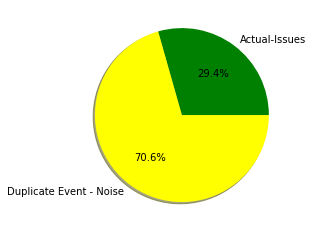

In [24]:
df_dedup = pd.read_sql("select * from dedup" , Database().getConn())
df_archive = pd.read_sql("select * from archive", Database().getConn())
fig, ax = plt.subplots()

source = ["Actual-Issues", "Duplicate Event - Noise"]
colors = ['green','yellow']
values = [len(df_dedup), len(df_archive)]


ax.pie(values, labels=source, colors=colors, autopct='%.1f%%', shadow=True)

plt.show()

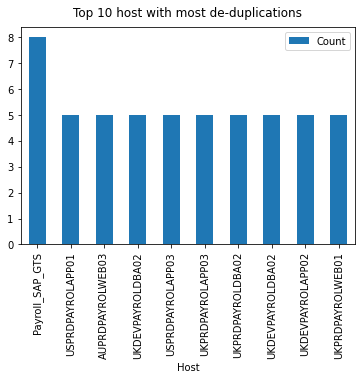

In [25]:
df_dedup = df_dedup.sort_values(by="Count", ascending=False)
df_dedup[:10].plot(kind="bar", by="Count", x="Host")
plt.title("Top 10 host with most de-duplications", y=1.02);
# df_dedup